# Solar radiation and land surface temperature

Binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/UCL-EO/geog0133/HEAD?filepath=docs%2Fnotebooks_lab%2F005_Solar_Practical.ipynb)

Answers
[![answers](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/UCL-EO/geog0133/HEAD?filepath=docs%2Fnotebooks_lab%2F005_Solar_Practical_answers.ipynb)


## Introduction

Two critical driving variables we will need to understand patterns and responses of terrestrial vegetation are the incident shortwave solar radiation and temperature at the land surface. In this practical, we will explore the variations in shortwave solar radiation as a function of latitude and time of year, and associate surface temperature with these. 

In a future exercise, we will use such data to drive a model of carbon dynamics by vegetation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from geog0133.solar import solar_model,radiation
import scipy.ndimage.filters
from geog0133.cru import getCRU,splurge
from datetime import datetime, timedelta
# import codes we need into the notebook

## Incident PAR

Solar radiation drives the Earth system and strongly impacts the terrestrial Carbon cylcle. 

We will use a model of solar radiation to examine diurnal and seasonal variations. We use the [PyEphem](http://rhodesmill.org/pyephem/) Python package, which allows us to calculate the position of the sun with respect to an observer on Earth. So we need time as well as longitude and latitude.

Before we do that, let's make sure we understand the main factors causing these variations.

We will use the `solar_model` method that gives time axis in units of Julian days, as well as the solar zenith angle (in degrees), the Earth-Sun distance, as well as the solar radiation in mol(photons)/m^2s.


In [2]:
help(solar_model)

Help on function solar_model in module geog0133.solar:

solar_model(secs, mins, hours, days, months, years, lats, longs, julian_offset='2000/1/1')
    A function that calculates the solar zenith angle (sza, in
    degrees), the Earth-Sun distance (in AU), and the instantaneous 
    downwelling solar radiation in mol(photons) per square meter per
    second for a set of time(s) and geographical locations.



A small aside on defining dates. We will be defining the date by the day of year (`doy`) when we run these exercises, but the code we are using requires a definition of date as days and month. To convert between these in Python, we use the `datetime` module to specify the 1st of January for the given year in the variable `datetime_object`, then add on the `doy` (actually `doy-1` because when `doy` is 1 we mean January 1st). We then specify `day` `month` and `year` as `datetime_object.day`,`datetime_object.month`,`datetime_object.year`

In [3]:
# set a date by year and doy
year = 2020
doy = 32

# convert to datetime object
datetime_object = datetime(year,1,1)+timedelta(doy-1)
# extract day, month and year
datetime_object.day,datetime_object.month,datetime_object.year

(1, 2, 2020)

Orbital mechanics impose a variation in the Earth-Sun distance over the year. This is typically expressed in [Astronomical Units](https://en.wikipedia.org/wiki/Astronomical_unit) (AU), so relative to the mean Earth-Sun distance.

The Exo-atmospheric solar radiation E0 ($W/m^2$) (total shortwave radiation) is defined as:

$$
E0 = \frac{G_{sc}}{r^2}
$$

where $G_{sc}$ is the Solar Constant (around 1361 $W/m^2$) and $r$ is the Earth-Sun distance in AU (inverse-squared law). 

Around half of the SW energy is in the PAR region, so to calculate PAR, we scale by 0.5. 

The energy content of PAR quanta is around $220.e-3$  $MJmol^{-1}$, so the top of atmosphere (TOA) PAR solar radiation is $\frac{E0}{2 \times 220.e-3}$ $mol/{m^2s}$, so 3093 = $mol/{m^2s}$ at 1 AU.

We can use `solar_model` to calculate this distance and ipar variation, and visualise the orbit:

In [4]:
year=2020
doys = np.arange(1,366)
dts = [datetime(year,1,1) + timedelta(int(doy)-1) for doy in doys]
# solar distance in AU
print()
distance = np.array([solar_model(0.,[0],[12],\
            dt.day,dt.month,dt.year,0,0)[2] for dt in dts]).ravel()
swrad    = np.array([solar_model(0.,[0],[12],\
            dt.day,dt.month,dt.year,0,0)[3] for dt in dts]).ravel()
print(f'distance range : {distance.min():6.4f} to {distance.max():6.4f} AU')
print(f'swrad    range : {swrad.min():6.0f} to {swrad.max():6.0f} mol/ (m^2 s)')


distance range : 0.9832 to 1.0167 AU
swrad    range :   5985 to   6400 mol/ (m^2 s)


![Seasons](https://upload.wikimedia.org/wikipedia/commons/f/f0/Seasons1.svg)

![Earth-Sun distance](images/earth.gif)



This [animation](geog0133/sunplot.py) shows the variation in Earth-Sun distance. The eccentricity of the Earth orbit is **really quite low** (0.0167) (a circle at 1 AU is shown as a dashed line) so the solar radiation varies by around 7% over the year. The ipar variation is illustrated by the size of the Sun in this animation, the diameter of which is made proportional to ipar but exxagerated to the 4th power for illustration. 

#### Exercise

* At what time of year is PAR radiation incident on Earth the highest?
* Why is this so?

### The seasons

We need to take account of this annual (7%) variation when we model PAR interception by vegetation, but it is not the strongest cause of variation over the year. Solar radiation is projected onto the Earth surface. We can express this projection by the cosine of the solar zenith angle. When the Sun is directly overhead (zenith angle zero degrees), then the projection is 1. As the zenith angle increases, the projected radiation decreases until it is 0 at a zenith angle of 90 degrees.


The seasons are not directly related to the Earth-Sun distance variations then. They arise in the main because the Earth is tilted on its axis by 23.5 degrees (obliquity).

![](https://www.nasa.gov/sites/default/files/thumbnails/image/axis_.png)

We will use `solar_model`  to calculate the amount of incoming PAR. To do this, we assume:

* that PAR is around 50% of total downwelling (shortwave) radiation,
* that the optical thickness ($\tau$) of the atmosphere in the PAR region is around 0.2
* and that we multiply by all this by $\cos(sza)$ to project on to a flat surface.

Let's look at how that varies over the year, for some different latitudes.

[80, 172, 264, 355]


(0.0, 365.0)

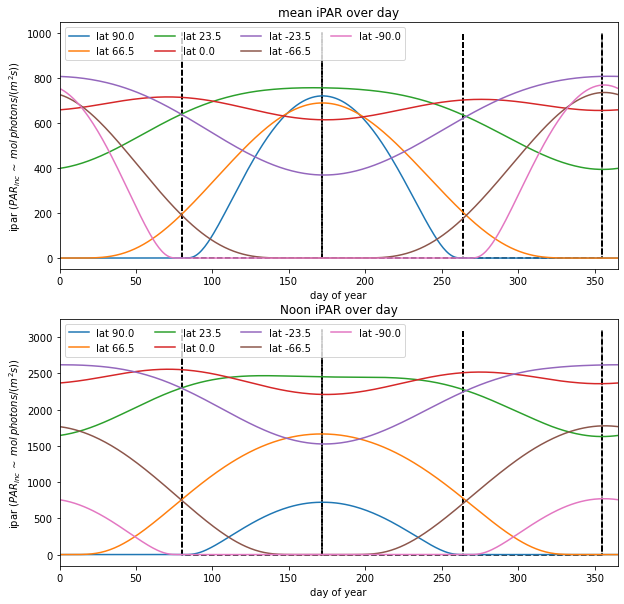

In [5]:
year=2020
# plot solstices and equinox
es = [datetime(year,3,21),datetime(year,6,21),datetime(year,9,21),datetime(year,12,21)]
des = [(e - datetime(year,1,1)).days for e in es]
print(des)

doys = np.arange(1,366)
dts = [datetime(year,1,1) + timedelta(int(doy)-1) for doy in doys]


tau = 0.2
parprop = 0.5 

latitudes = [90,90-23.5,23.5,0,-23.5,23.5-90,-90]
fig,axs = plt.subplots(2,1,figsize=(10,10))

# equinox and solstice as dashed lines
axs[0].plot(np.array([des]*3).T.ravel(),np.array([[0]*4,[1000]*4,[0]*4]).T.ravel(),'k--')
axs[1].plot(np.array([des]*3).T.ravel(),np.array([[0]*4,[3100]*4,[0]*4]).T.ravel(),'k--')

for i,lat in enumerate(latitudes):
    swrad  = np.array([solar_model(0.,[0,30],np.arange(25),dt.day,dt.month,dt.year,lat,0)[3] for dt in dts])
    sza  = np.array([solar_model(0.,[0,30],np.arange(25),dt.day,dt.month,dt.year,lat,0)[1] for dt in dts])
    mu = np.cos(np.deg2rad(sza))
    ipar = (swrad* mu * np.exp(-tau/mu) * parprop)
    ipar[ipar<0] = 0
    axs[0].plot(doys,ipar.mean(axis=1),label=f'lat {lat:.1f}')
    axs[1].plot(doys,ipar.max(axis=1),label=f'lat {lat:.1f}')
     
axs[0].legend(loc='best',ncol=4)
axs[0].set_title(f'mean iPAR over day')
axs[0].set_xlabel('day of year')
axs[0].set_ylabel('ipar ($PAR_{inc}\,\sim$ $mol\, photons/ (m^2 s)$)')
axs[0].set_xlim(0,doys[-1])
axs[1].legend(loc='best',ncol=4)
axs[1].set_title(f'Noon iPAR over day')
axs[1].set_xlabel('day of year')
axs[1].set_ylabel('ipar ($PAR_{inc}\,\sim$ $mol\, photons/ (m^2 s)$)')
axs[1].set_xlim(0,doys[-1])

Now, lets look at variation over the day, for some selected days:

[80, 172, 264, 355]


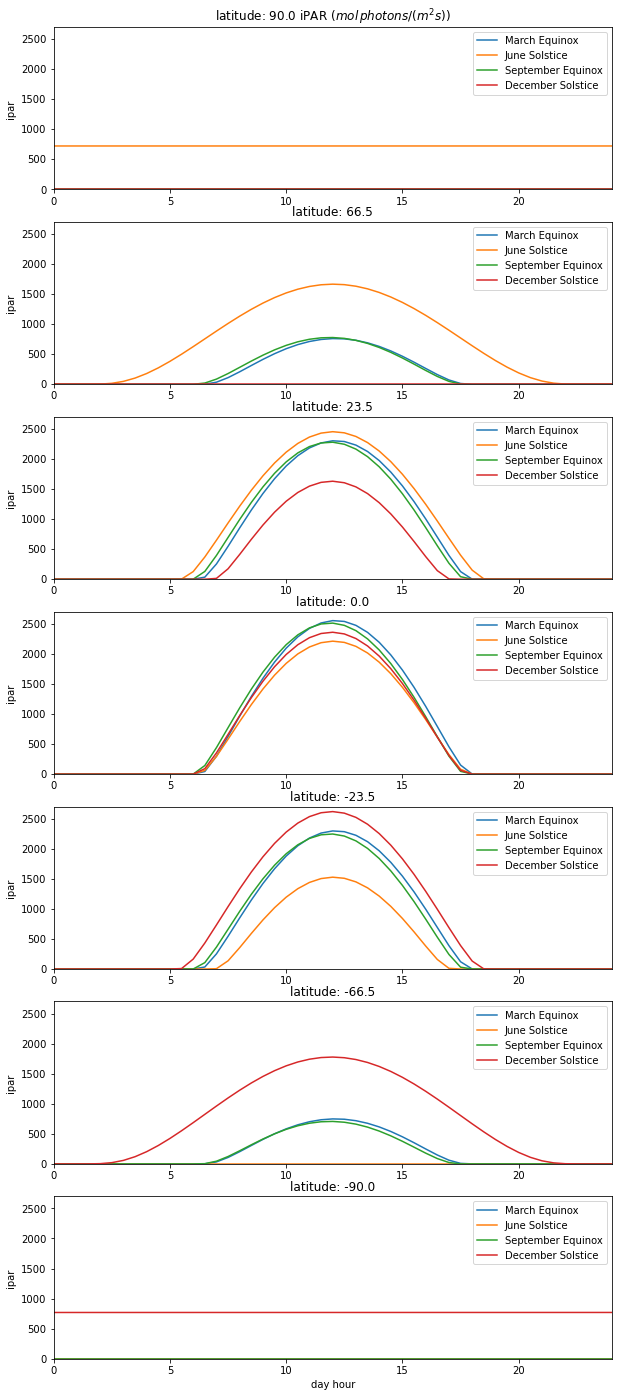

In [6]:
tau=0.2
parprop=0.5
year=2020

# equinox and solstice
es = [datetime(year,3,21),datetime(year,6,21),datetime(year,9,21),datetime(year,12,21)]
des = [(e - datetime(year,1,1)).days for e in es]
print(des)

latitudes = [90,90-23.5,23.5,0,-23.5,23.5-90,-90]
fig,axs = plt.subplots(len(latitudes),1,figsize=(10,3.5*len(latitudes)))

legends = ['March Equinox','June Solstice','September Equinox','December Solstice']

for i,lat in enumerate(latitudes):
    axs[i].set_title(f'latitude: {lat:.1f}')
    axs[i].set_ylabel('ipar ')
    axs[i].set_xlim(0,24)
    axs[i].set_ylim(0,2700)
    for j,doy in enumerate(des):
        # datetime
        dt = datetime(year,1,1) + timedelta(doy-1)
        # call solar_model
        jd, sza, distance, solar_radiation = solar_model(
                0.,np.array([0.,30]),np.arange(25),dt.day,dt.month,dt.year,lat, 0)
        mu = np.cos(np.deg2rad(sza))
        s = (solar_radiation*parprop * np.exp(-tau/mu) * mu)
        axs[i].plot((jd-jd[0])*24,s,label=legends[j])
    axs[i].legend(loc='best')
    
axs[0].set_title(f'latitude: {latitudes[0]:.1f} iPAR ($mol\, photons/ (m^2 s)$)')
_=axs[-1].set_xlabel('day hour')

#### Exercise

* Describe and explain the patterns of iPAR as a function of day of year and latitude.
* Comment on the likely reality of these patterns.

## Weather generation

To run our photosynthesis model, we need to know the temperature as well as the IPAR. That is rather complicated to model, so we will use observational data to drive the model. We choose the interpolated [CRU climate dataset](https://sites.uea.ac.uk/cru/data) for this. 

You can select this using the [`getCRU()`](geog0133/cru.py) function for a given latitude, longitude and year (2011 to 2019 inclusive here). This gives you access to **monthly** minimum and maximum temperatures, `f['tmn']` and `f['tmx']` respectively, as well as cloud cover percentage `f['cld']`. The dataset is for the land surface only. If you specify somewhere in the ocean, you will get an interpolated result.

### Scaling iPAR by cloud cover

We will use the cloud percentage to reduce iPAR, by setting a reduction factor by 1/3 (to a value of 2/3) on cloudy days (when `f['cld']` is 100) and 1 when there is no cloud.

    scale = 1 - f['cld']/300

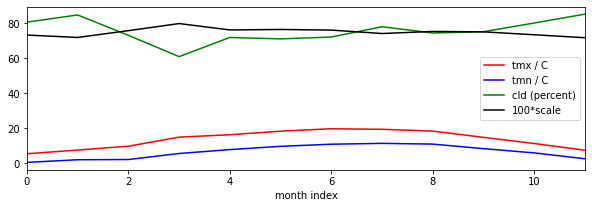

In [7]:
from geog0133.cru import getCRU

f = getCRU(2019,longitude=0,latitude=56)
tmx = f['tmx']
tmn = f['tmn']
cld = f['cld']

plt.figure(figsize=(10,3))
plt.plot(tmx,'r',label='tmx / C')
plt.plot(tmn,'b',label='tmn / C')
plt.plot(cld,'g',label='cld (percent)')
# irradiance reduced by 1/3  on cloudy days
plt.plot(100*(1-cld/300.),'k',label='100*scale')
plt.xlabel('month index')
plt.legend(loc='best')
_=plt.xlim(0,11)

### Synthesizing diurnal temperature

Since we only have monthly minimum and maximum temperature, we need to be able to estimate the diurnal variation of temperature from these. We can broadly achieve this by scaling by normalised IPAR. However, there will be a time lag between greater radiation input and temperature caused by inertia in the system. We can mimic this effect with a one-sided smoothing filter that 'smears' the temperature forward in time. The degree of smearing is controlled by the filter width parameter `f` (e.g. 8 hours). This is achieved in the function `splurge`:

In [8]:
def splurge(ipar,f=8.0,plot=False):
    '''
    Spread the quantity ipar forward in time
    using a 1-sided exponential filter of width 
    f * 2.
    
    Arguments:
        ipar: array of 1/2 hourly time step ipar values 
              (length 48)
              
    Keyword:
        f : filter characteristic width. Filter is
            exp(-x/(f*2))
            
    Return:
        ipar_ : normalised, splurged ipar array
    '''
    if f == 0:
        return (ipar-ipar.min())/(ipar.max()-ipar.min())
    # build filter over large extent
    nrf_x_large = np.arange(-100,100)
    # filter function f * 2 as f is in hours
    # but data in 1/2 hour steps
    nrf_large = np.exp(-nrf_x_large/(f*2))    
    # 1-sided filter
    nrf_large[nrf_x_large<0] = 0
    nrf_large /= nrf_large.sum()
    ipar_ = scipy.ndimage.filters.convolve1d(ipar, nrf_large,mode='wrap')
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(nrf_x_large,nrf_large)
    return (ipar_-ipar_.min())/(ipar_.max()-ipar_.min())


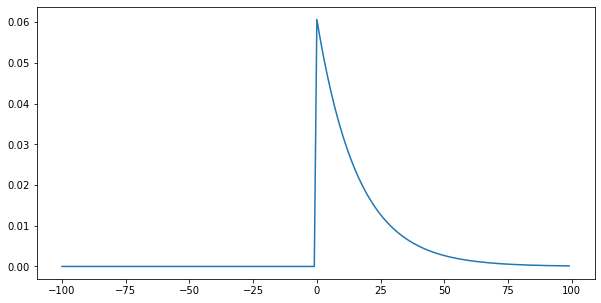

In [9]:
# Calculate solar position over a day, every 30 mins
year=2020
doy =80
latitude, longitude = 51,0
dt = datetime(year,1,1) + timedelta(doy-1)

# solar radiation
jd, sza, distance, solar_radiation = solar_model(
    0.,np.array([0.,30.]),np.arange(0,24),dt.day,dt.month,dt.year,
    latitude, longitude)

hour = (jd-jd[0])*24 
# cosine
mu = np.cos(np.deg2rad(sza))
ipar = solar_radiation* parprop * np.exp(-tau/mu) * mu

# show filter
_=splurge(ipar,f=8,plot=True)

f=0, peak time shifted from 12.0 hrs to 12.0 hrs
f=1, peak time shifted from 12.0 hrs to 13.0 hrs
f=2, peak time shifted from 12.0 hrs to 13.5 hrs
f=3, peak time shifted from 12.0 hrs to 14.0 hrs
f=4, peak time shifted from 12.0 hrs to 14.5 hrs
f=5, peak time shifted from 12.0 hrs to 15.0 hrs
f=6, peak time shifted from 12.0 hrs to 15.0 hrs
f=7, peak time shifted from 12.0 hrs to 15.0 hrs


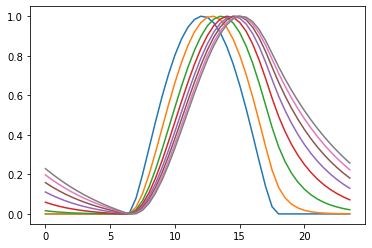

In [10]:
# smear ipar
# filter length f (hours)
f = 1.0 # hours 
for f in np.arange(0,8):
    ipar_ = splurge(ipar,f=f)
    plt.plot(hour,ipar_)
    print(f'f={f}, peak time shifted from {hour[np.argmax(ipar)]:.1f} hrs to {hour[np.argmax(ipar_)]:.1f} hrs')

A value of `f` of `8` give a 2 hour delay in the peak of around 2 hours which is a reasonable average value we can use to mimic temperature variations. A simple model of diurnal temperature variatioins then is to simply scale this by the monthly temperature minimum and maximum values:

    Tc = ipar_*(Tmax-Tmin)+Tmin
    
One problem with this approach is that the variation we achieve in temperature (and IPAR) is significantly less than in reality. This can reduce the apparent variation in CO2 fluxes. In practice, when modellers attempt to estimate instantaneous (or short time-integral) values from means, they insert additional random variation to match some other sets of observed statistical variation (including correlations). We ignore that here, for simplicity.

In [11]:
import numpy as np
from datetime import datetime
from datetime import timedelta

def radiation(latitude,longitude,doy,
              tau=0.2,parprop=0.5,year=2019,
              Tmin=5.0,Tmax=30.0,f=8.0):
    '''
    Simple model of solar radiation making call 
    to solar_model(), calculating modelled
    ipar 
    
    Arguments:
    latitude : latitude (degrees)
    longitude: longitude (degrees)
    doy:  day of year (integer)
    
    Keywords:
    
    tau:     optical thickness (0.2 default)
    parprop: proportion of solar radiation in PAR
    Tmin:    min temperature (C) 20.0 default
    Tmax:    max temperature (C) 30.0 default
    year:    int 2020 default
    f:       Temperature smearing function characteristic
             length (hours)
    
    '''
    # Calculate solar position over a day, every 30 mins
    # for somewhere like London (latitude 51N, Longitude=0)
    dt = datetime(year,1,1) + timedelta(doy-1)

    jd, sza, distance, solar_radiation = solar_model(
        0.,np.array([0.,30.]),np.arange(25),dt.day,dt.month,dt.year,
        latitude, 0,julian_offset=f'{year}/1/1')
    mu = np.cos(np.deg2rad(sza))
    
    n = mu.shape[0]

    ipar = solar_radiation* parprop * np.exp(-tau/mu) * mu  # u mol(photons) / (m^2 s)
    fd = getCRU(year,longitude=longitude,latitude=latitude)
    Tmax = fd['tmx'][dt.month-1]
    Tmin = fd['tmn'][dt.month-1]
    cld = fd['cld'][dt.month-1]
    scale = (1-cld/300.)
    print(f'Tmin {Tmin:.2f} Tmax {Tmax:.2f} Cloud {cld:.2f} Scale {scale:.2f}')
    # reduce irradiance by 1/3 on cloudy day
    ipar = ipar * scale
    # smear ipar
    ipar_ = splurge(ipar,f=f)
    # normalise
    Tc = ipar_*(Tmax-Tmin)+Tmin
    #Tc = (Tc-Tc.min())
    #Tc = Tc/Tc.max()
    #Tc = (Tc*(Tmax-Tmin) + (Tmin))
    return jd-jd[0],ipar,Tc


We can now run the driver synthesis for some given latitude/longitude and time period:

Tmin 5.50 Tmax 11.60 Cloud 71.30 Scale 0.76
Tmin 12.20 Tmax 19.90 Cloud 64.20 Scale 0.79
Tmin 11.90 Tmax 19.20 Cloud 63.10 Scale 0.79
Tmin 5.20 Tmax 10.00 Cloud 81.60 Scale 0.73


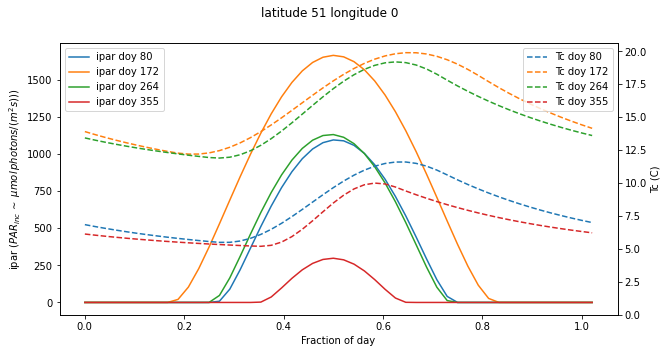

In [12]:
tau=0.2
parprop=0.5
year=2020

latitude = 51
longitude = 0

fig,ax=plt.subplots(1,1,figsize=(10,5))
ax2 = ax.twinx() 

# loop over solstice and equinox doys
for doy in [80,172,264,355]:
    jd,ipar,Tc = radiation(latitude,longitude,doy)
    
    ax.plot(jd-jd[0],ipar,label=f'ipar doy {doy}')
    ax2.plot(jd-jd[0],Tc,'--',label=f'Tc doy {doy}')
    
# plotting refinements
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_ylabel('ipar ($PAR_{inc}\,\sim$ $\mu mol\, photons/ (m^2 s))$)')
ax2.set_ylabel('Tc (C)')
ax.set_xlabel("Fraction of day")
ax2.set_ylim(0,None)
_=fig.suptitle(f"latitude {latitude} longitude {longitude}")

#### Exercise

* Use the `radiation()` function to explore ipar and temperature for different locations and times of year
* How are these patterns likely to affect what plants grow where?

## Discussion

In this practical, you should have developed an improved understanding of solar radiation and temperature. These are critical drivers for plants, and this sort of understanding is key to appreciating the overall patterns of vegetation growth and to developing models of terrestrial Carbon dynamics. Of course, there are many other factors that impinge on actual Carbon dynamics, not the least of which is modification of the environment by man. 

In the following lectures and practicals, we will integrate these drivers with process models. 